# Analyzing Embedded Flare Spectra

This notebook looks at the spectra resulting from embedding a 1D spectra into a 2D image and building an overlappogram from it.

In [1]:
import pathlib

import asdf
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import astropy.io.fits
import astropy.units as u
import astropy.wcs
from fiasco.io import Parser
from scipy.interpolate import PchipInterpolator
import sunpy.map
import sunpy.io._fits as sunpy_fits

from sunpy.coordinates import get_earth, Helioprojective
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support, ImageNormalize, LogStretch
from astropy.wcs.utils import wcs_to_celestial_frame

from synthesizAR.instruments.util import add_wave_keys_to_header

from mocksipipeline.util import read_data_cube
from mocksipipeline.instrument.configuration import moxsi_slot
from mocksipipeline.visualization import plot_labeled_spectrum
from overlappy.io import read_overlappogram

In [2]:
results_root = pathlib.Path('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/')

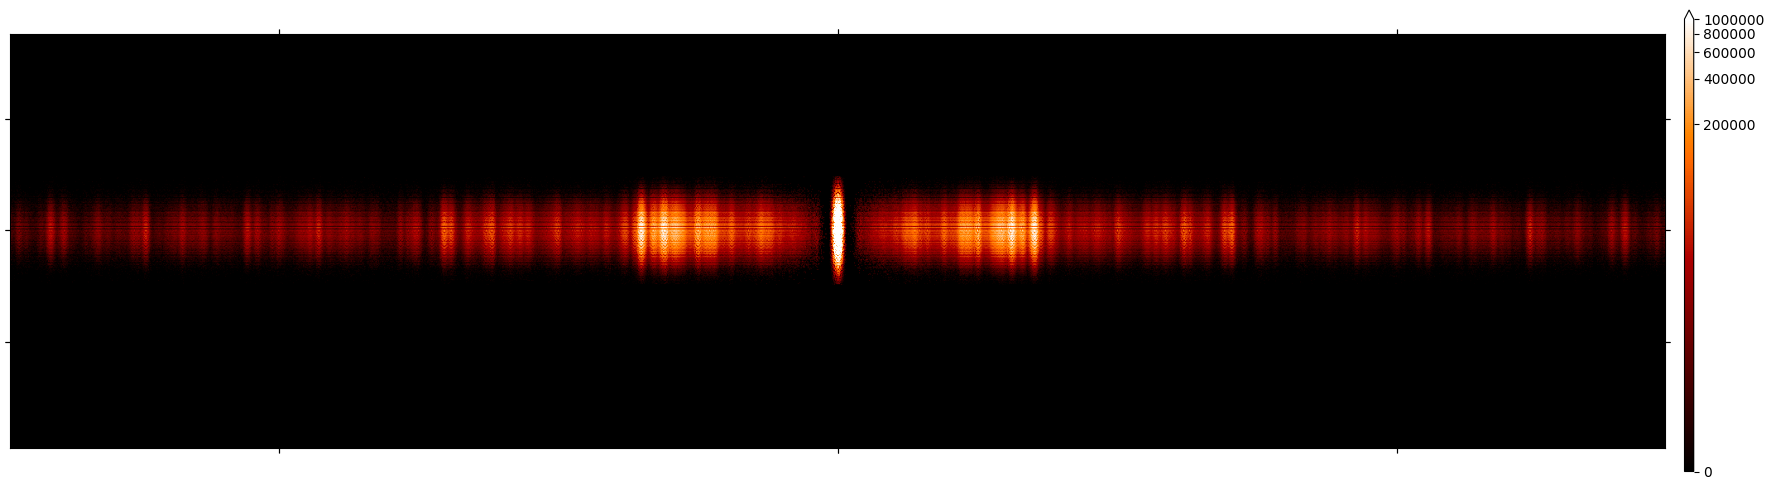

In [5]:
full_overlap = read_overlappogram(results_root / 'caspi_spectra_x5' / 'detector_images' / 'all_components.fits')
fig = plt.figure(figsize=(20,5),layout='tight')
ax = fig.add_subplot(projection=full_overlap[0,:500,:].wcs)
full_overlap[0,:500,:].plot(axes=ax,
                          cmap='hinodexrt',
                          #interpolation='none',
                          norm=ImageNormalize(vmax=1e6,stretch=LogStretch())
                    )
cbar_kwargs = {'extend':'max', 'extendfrac':0.02}
fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.01, aspect=50, **cbar_kwargs)

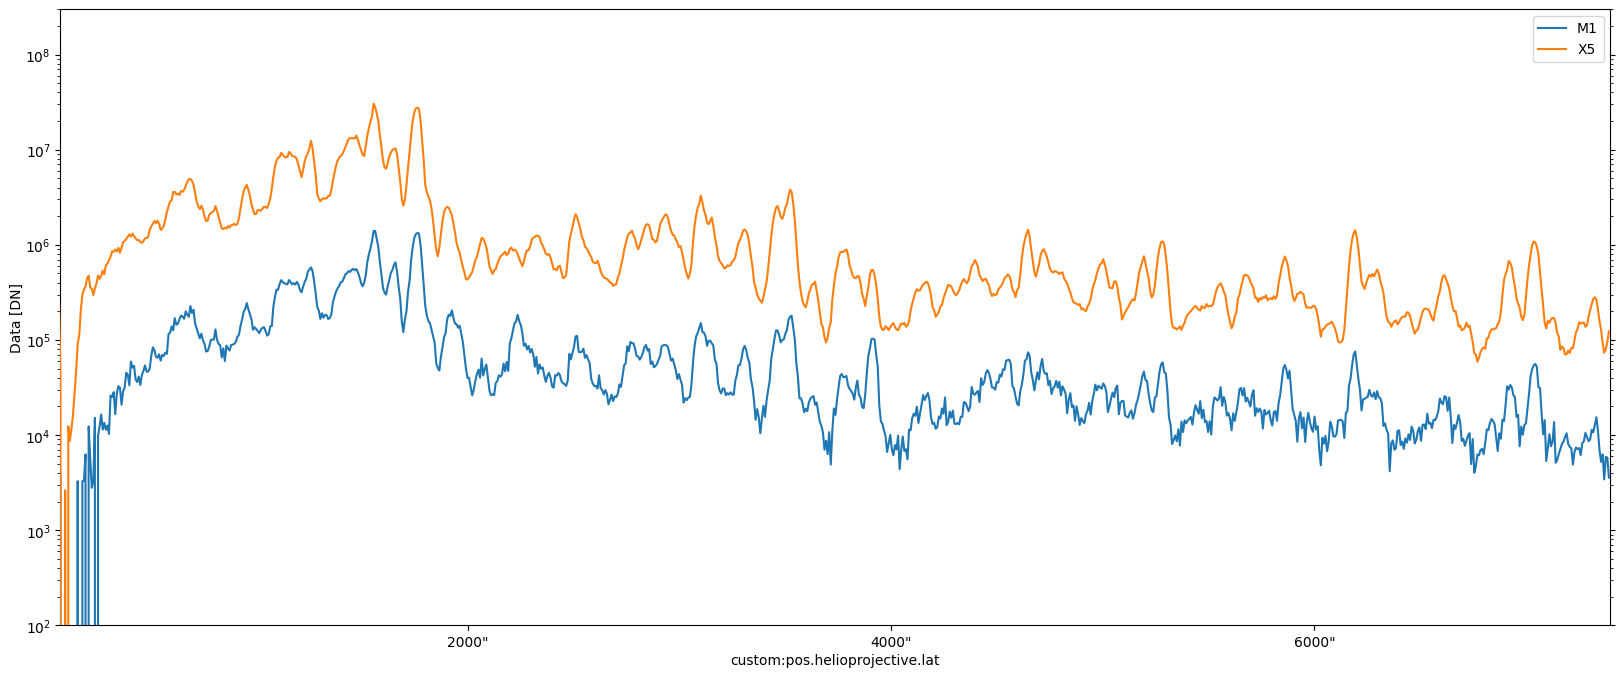

In [8]:
#overlappograms = {}
fig = plt.figure(figsize=(20,8))
ax = None
for k in ['m1', 'x5']:
    overlappogram = read_overlappogram(
        results_root / f'caspi_spectra_{k}' / 'detector_images' / 'all_components.fits'
    )
    if ax is None:
        ax = overlappogram[0,:500,:].rebin((500,1),operation=np.sum)[0,:].plot(label=k.upper())
    else:
        overlappogram[0,:500,:].rebin((500,1),operation=np.sum)[0,:].plot(axes=ax, label=k.upper())
ax.set_yscale('log')
ax.set_xlim(1010, 2000)
ax.set_ylim(1e2, 3e8)
ax.set_ylabel('Data [DN]')
ax.legend()

We need to understand what the highest order is that we need to model, i.e. at what's the highest order that crosses the threshold of making a significant contribution to the total emission?

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:932: RuntimeWarning: invalid value encountered in multiply
  new_data = self.data * value
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:932: RuntimeWarning: invalid value encountered in multiply
  new_data = self.data * value
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/si

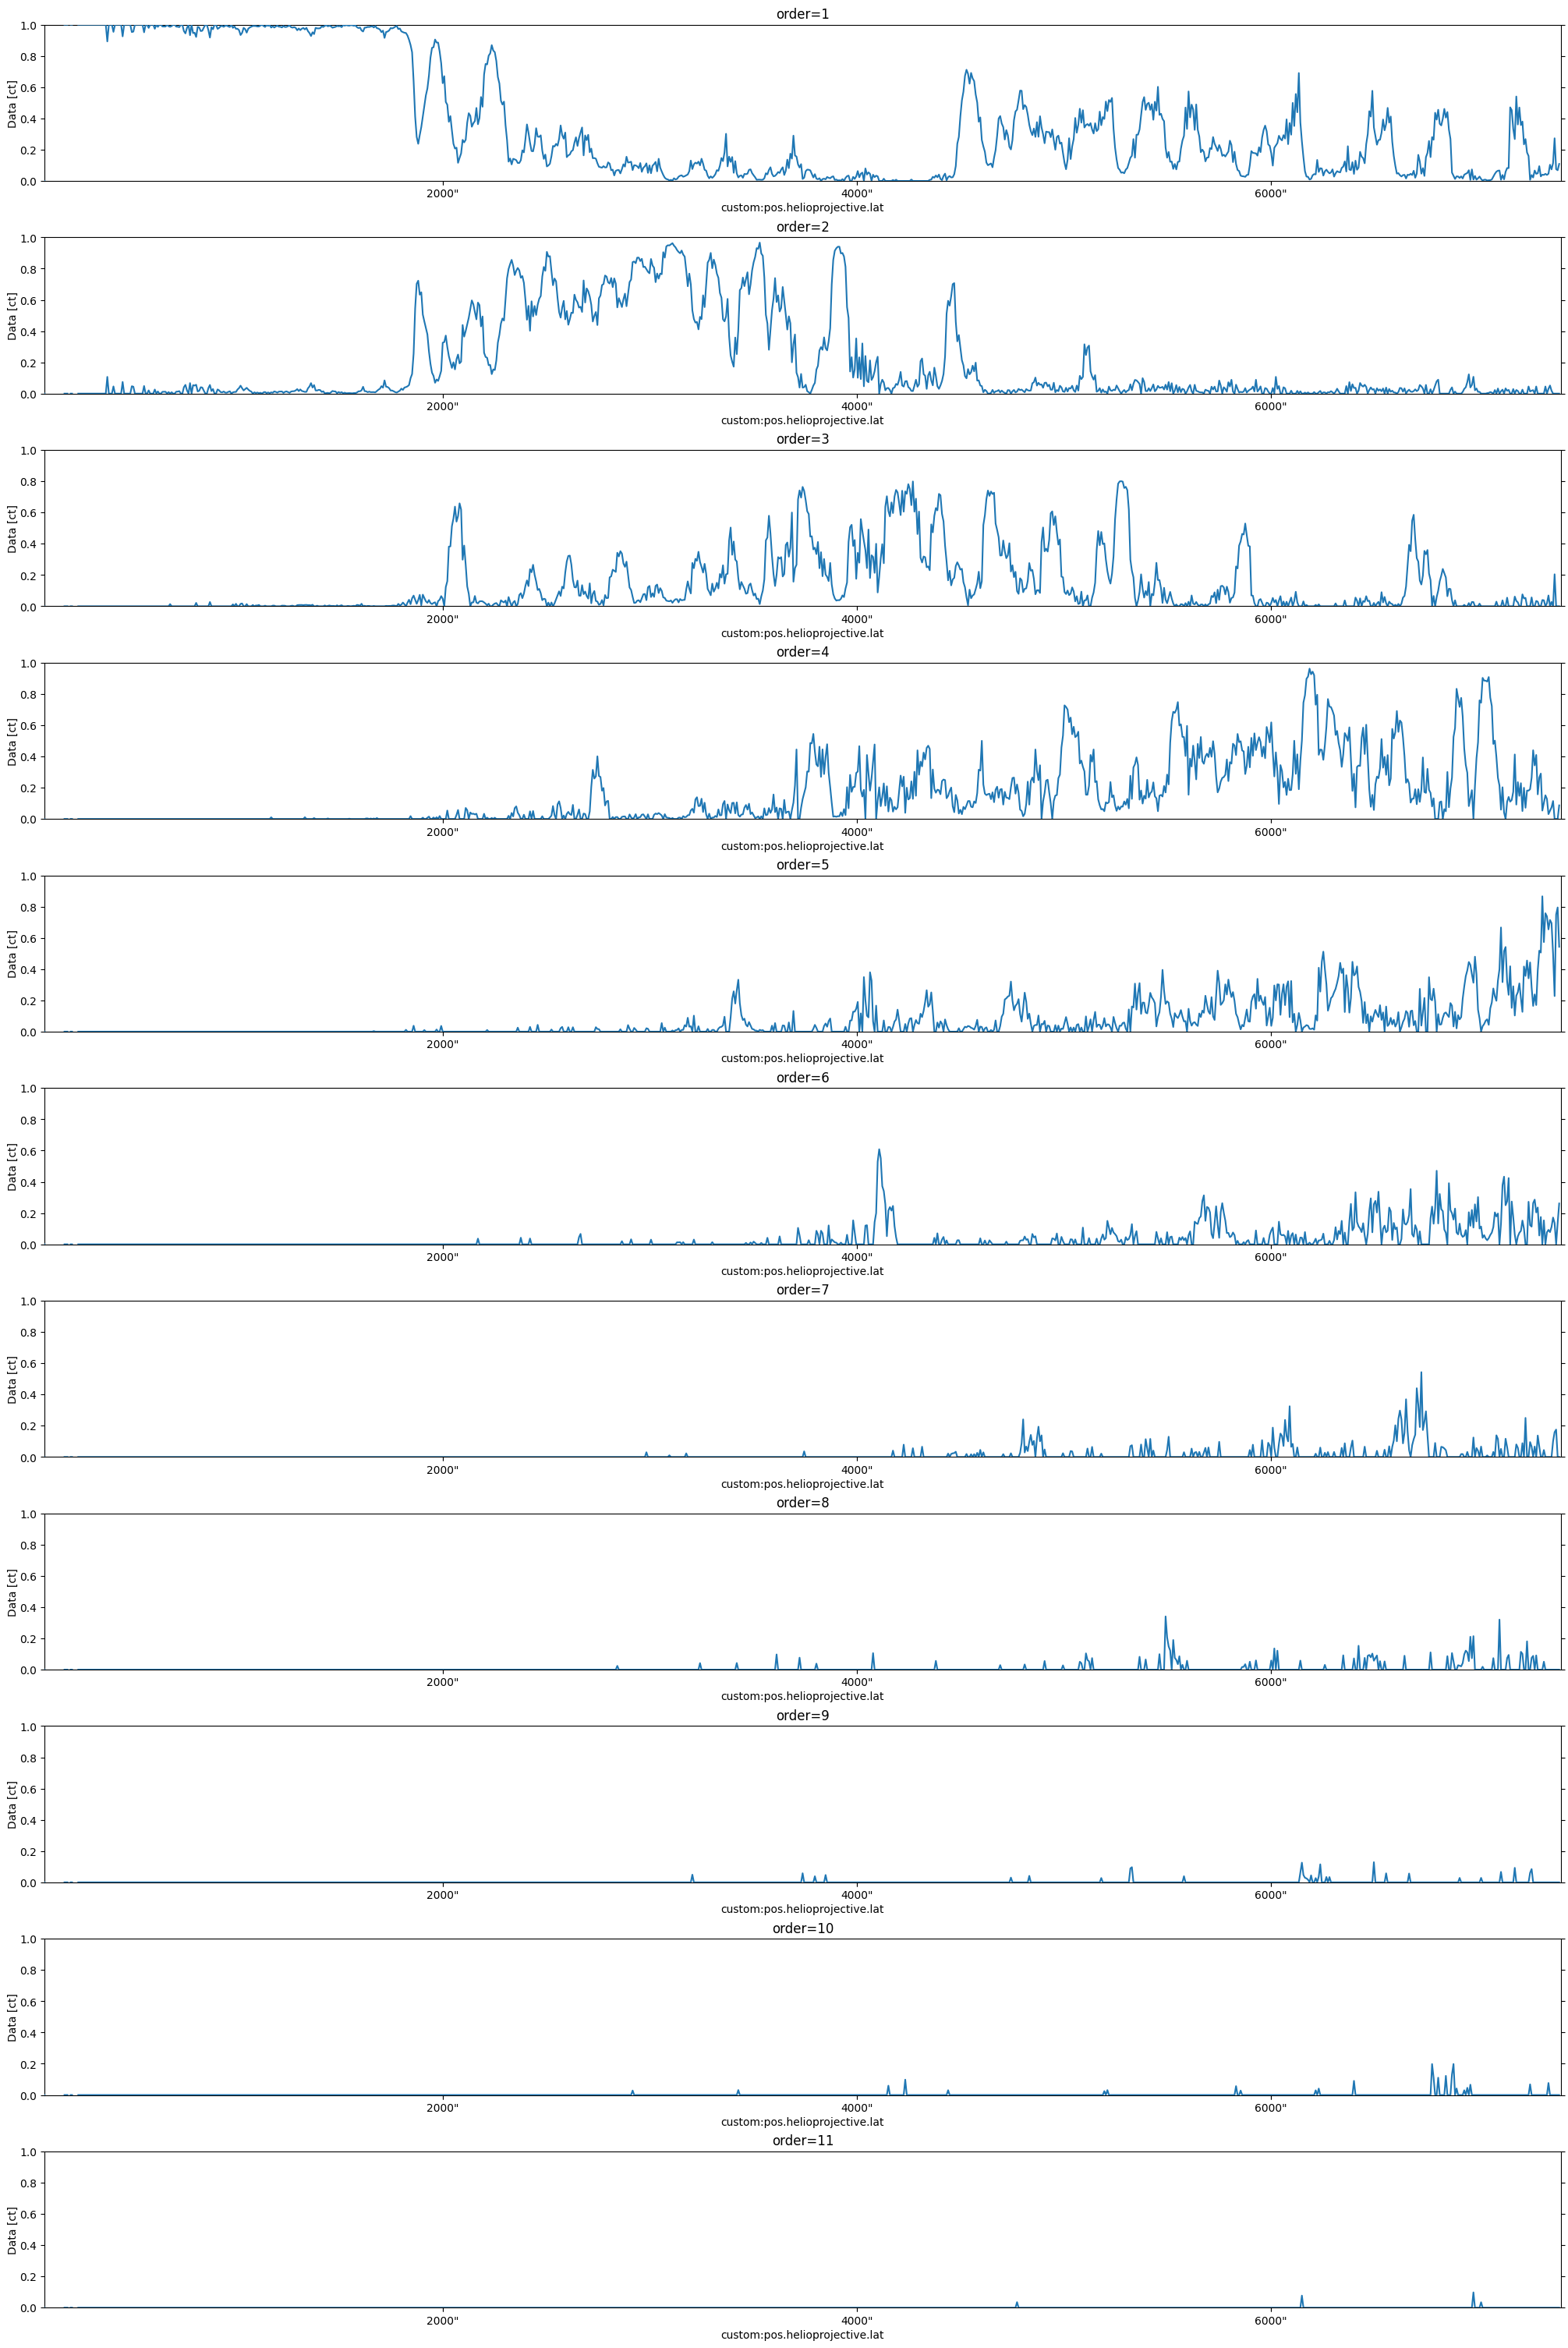

In [54]:
fig = plt.figure(figsize=(20,30),layout='constrained')
i_ax = 0
full_overlap = read_overlappogram(results_root / 'caspi_spectra_m1_all_orders' / 'detector_images' / 'all_components.fits')
full_overlap = full_overlap[0,:500,:].rebin((500,1),operation=np.sum)[0,:]
filenames = sorted((results_root / 'caspi_spectra_m1_all_orders' / 'detector_images').glob('spectrogram_slot*.fits'),
                   key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
for filename in filenames:
    order = int(filename.name.split('.')[0].split('_')[-1])
    if order > 0:
        overlap_component = read_overlappogram(filename)
        rebinned_spec = overlap_component[0,:500,:].rebin((500,1),operation=np.sum)[0,:]
        ax = fig.add_subplot(11, 1, i_ax+1, projection=rebinned_spec.wcs)
        ratio = rebinned_spec / full_overlap.data
        ratio.plot(axes=ax)
        ax.set_xlim(1010, 2000)
        ax.set_ylim(0, 1)
        ax.label_outer()
        ax.set_title(f'order={order}')
        i_ax += 1

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:932: RuntimeWarning: invalid value encountered in multiply
  new_data = self.data * value
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:932: RuntimeWarning: invalid value encountered in multiply
  new_data = self.data * value
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/si

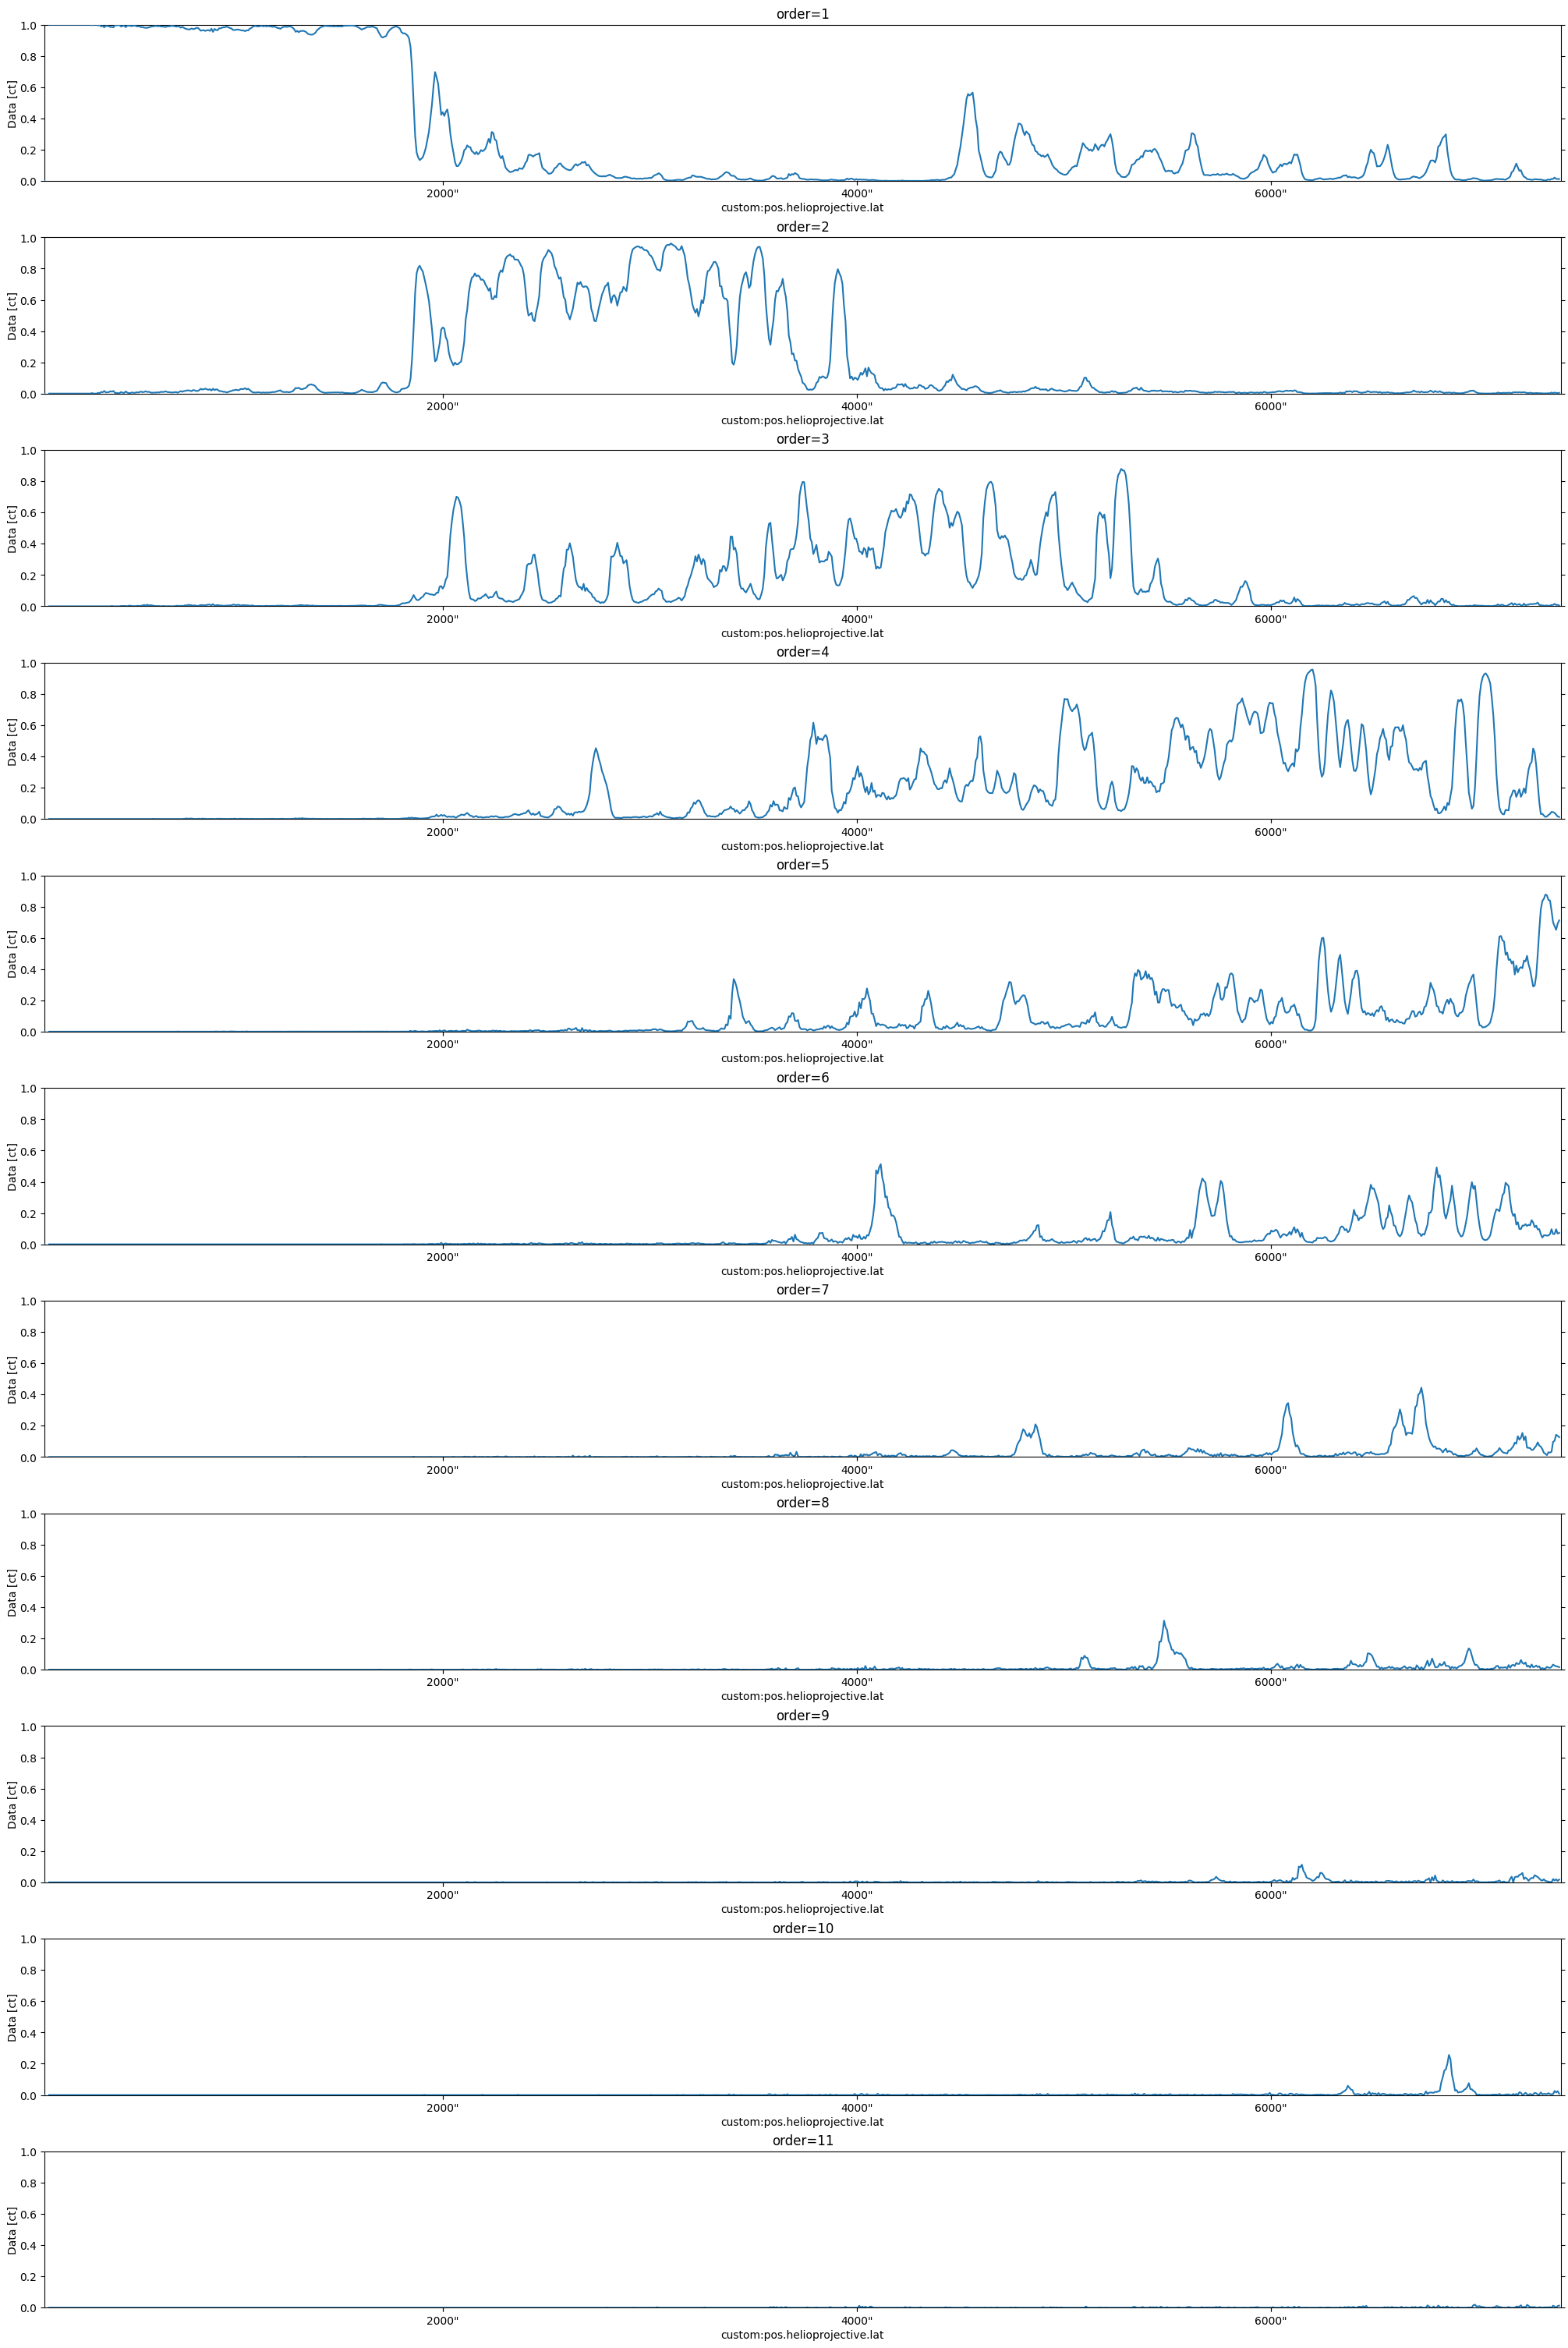

In [55]:
fig = plt.figure(figsize=(20,30),layout='constrained')
i_ax = 0
full_overlap = read_overlappogram(results_root / 'caspi_spectra_x5_all_orders' / 'detector_images' / 'all_components.fits')
full_overlap = full_overlap[0,:500,:].rebin((500,1),operation=np.sum)[0,:]
filenames = sorted((results_root / 'caspi_spectra_x5_all_orders' / 'detector_images').glob('spectrogram_slot*.fits'),
                   key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
for filename in filenames:
    order = int(filename.name.split('.')[0].split('_')[-1])
    if order > 0:
        overlap_component = read_overlappogram(filename)
        rebinned_spec = overlap_component[0,:500,:].rebin((500,1),operation=np.sum)[0,:]
        ax = fig.add_subplot(11, 1, i_ax+1, projection=rebinned_spec.wcs)
        ratio = rebinned_spec / full_overlap.data
        ratio.plot(axes=ax)
        ax.set_xlim(1010, 2000)
        ax.set_ylim(0, 1)
        ax.label_outer()
        ax.set_title(f'order={order}')
        i_ax += 1

Make a component-wise plot for each flare class

In [4]:
with asdf.open('../data/line_lists/curated_line_list.asdf') as af:
    line_list = af.tree['data']

/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide


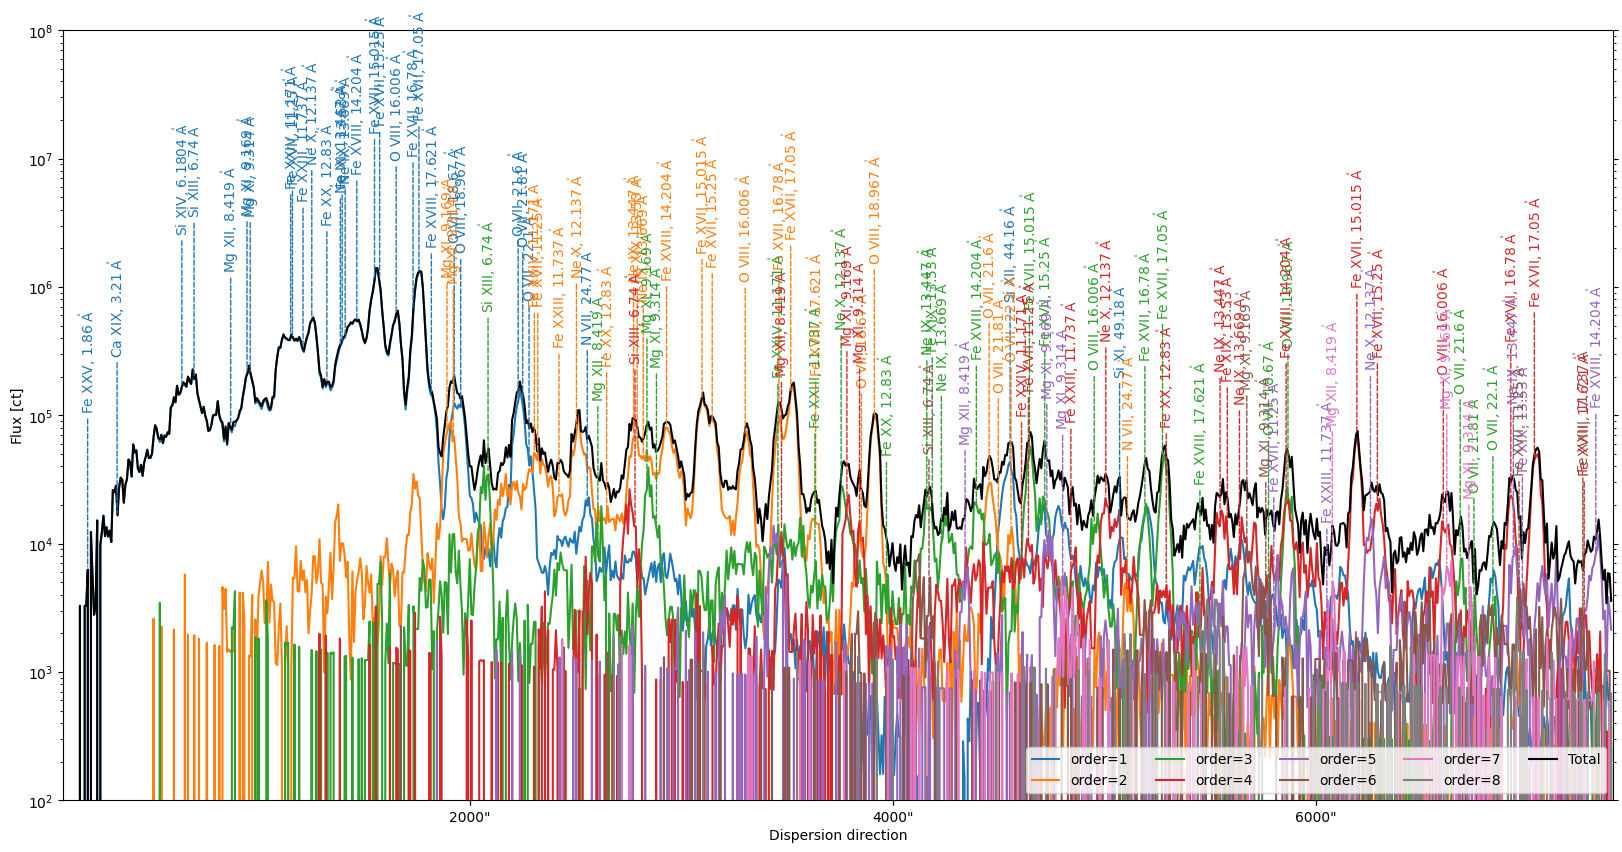

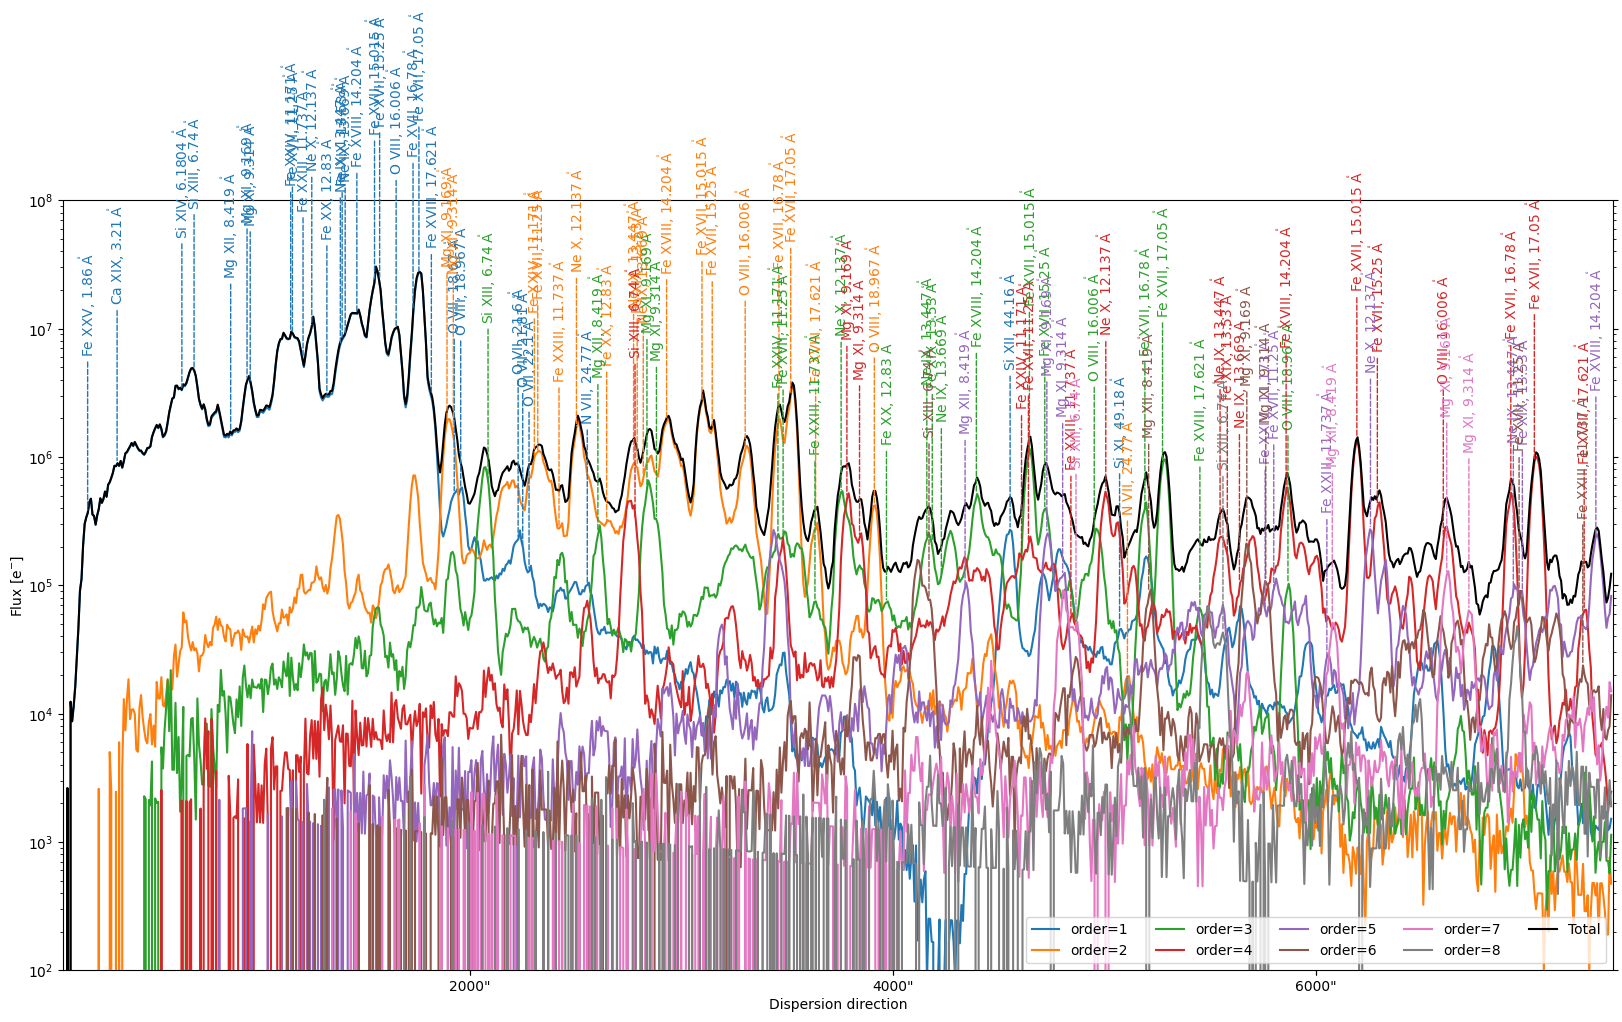

In [25]:
for k in ['m1', 'x5']:
    filenames = sorted((results_root / f'caspi_spectra_{k}' / 'detector_images').glob('spectrogram_slot*.fits'),
                       key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
    components_overlap = []
    for filename in filenames:
        order = int(filename.name.split('.')[0].split('_')[-1])
        if order > 0 and order <9:
            overlap_component = read_overlappogram(filename)
            components_overlap.append(overlap_component[:,:500,:].rebin((1,500,1),operation=np.sum))
    full_overlap = read_overlappogram(results_root / f'caspi_spectra_{k}' / 'detector_images' / 'all_components.fits')
    full_overlap = full_overlap[:,:500,:].rebin((1,500,1),operation=np.sum)
    plot_labeled_spectrum(components_overlap,
                          full_overlap,
                          line_list,
                          SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(overlap_component.wcs)),
                          threshold=0.1,
                          labels=[f'order={i}' for i in range(1,len(components_overlap)+1)],
                          x_lim=(1010,2000),
                          y_lim=(100,1e8))

What if we instead use a thin Be filter to try to reduce the response at the longer wavelengths to try to reduce the confusion between the first order components at longer wavelengths and the higher order components?

/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide


(<Figure size 2000x1000 with 1 Axes>,
 <WCSAxes: ylabel='Flux [$\\mathrm{DN}$]'>)

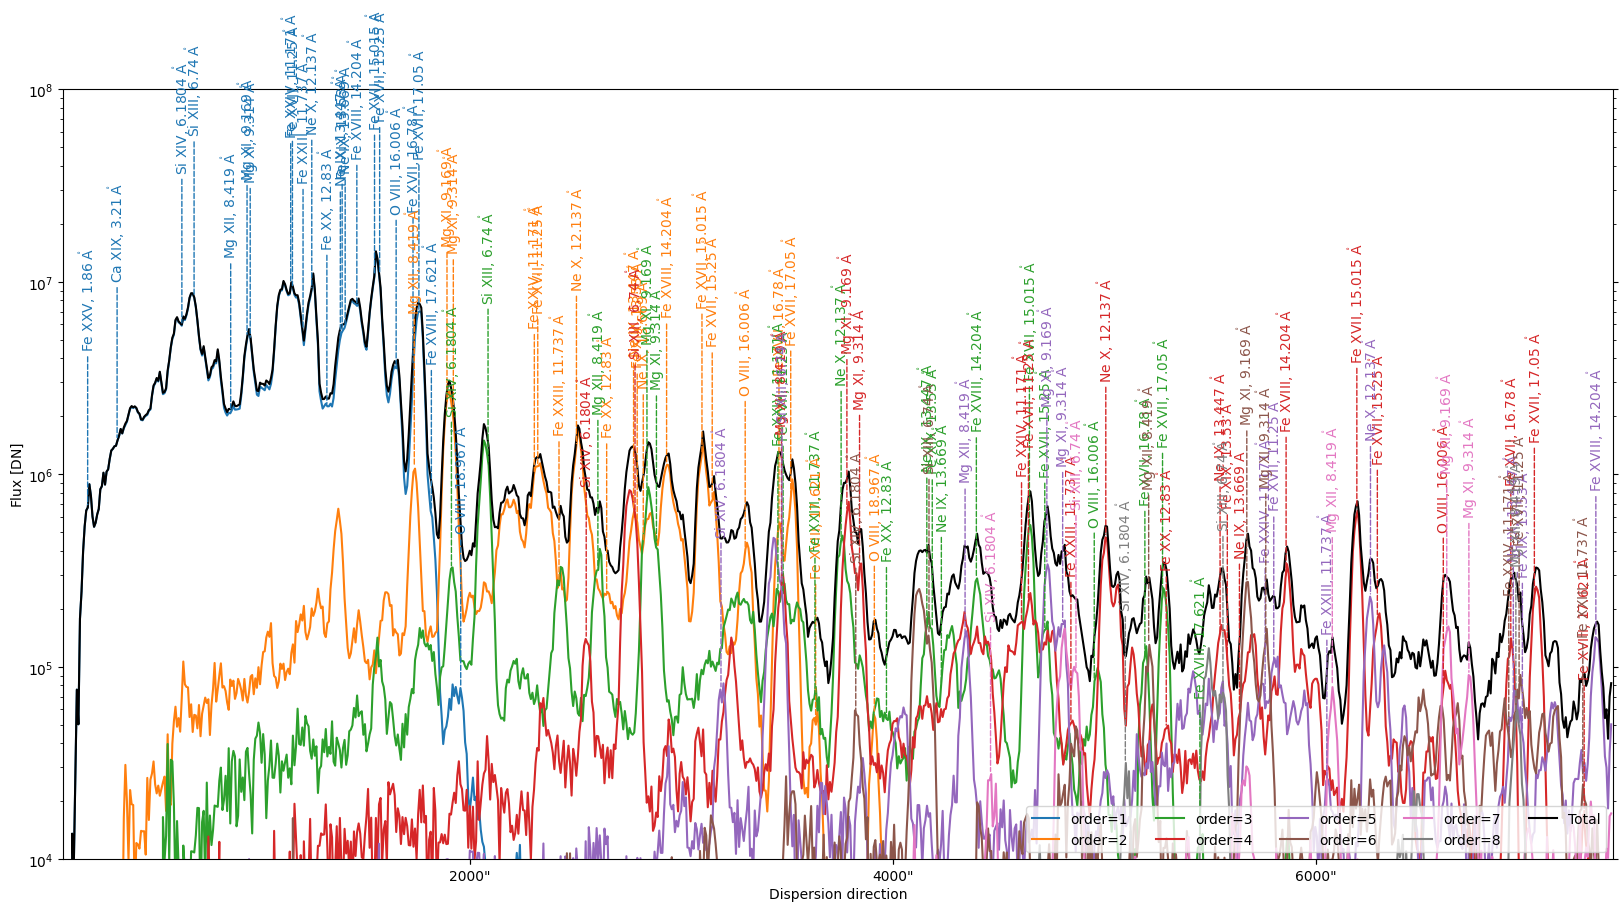

In [23]:
filenames = sorted((results_root / f'caspi_spectra_x5_be_thin' / 'detector_images').glob('spectrogram_slot*.fits'),
                   key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
components_overlap = []
for filename in filenames:
    order = int(filename.name.split('.')[0].split('_')[-1])
    if order > 0 and order <9:
        overlap_component = read_overlappogram(filename)
        components_overlap.append(overlap_component[:,:500,:].rebin((1,500,1),operation=np.sum))
full_overlap = read_overlappogram(results_root / f'caspi_spectra_x5_be_thin' / 'detector_images' / 'all_components.fits')
full_overlap = full_overlap[:,:500,:].rebin((1,500,1),operation=np.sum)
plot_labeled_spectrum(components_overlap,
                      full_overlap,
                      line_list,
                      SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(overlap_component.wcs)),
                      threshold=0.1,
                      labels=[f'order={i}' for i in range(1,len(components_overlap)+1)],
                      x_lim=(1010,2000),
                      y_lim=(1e4,1e8))

/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:47: RuntimeWarning: invalid value encountered in divide


(<Figure size 2000x1000 with 1 Axes>,
 <WCSAxes: ylabel='Flux [$\\mathrm{DN}$]'>)

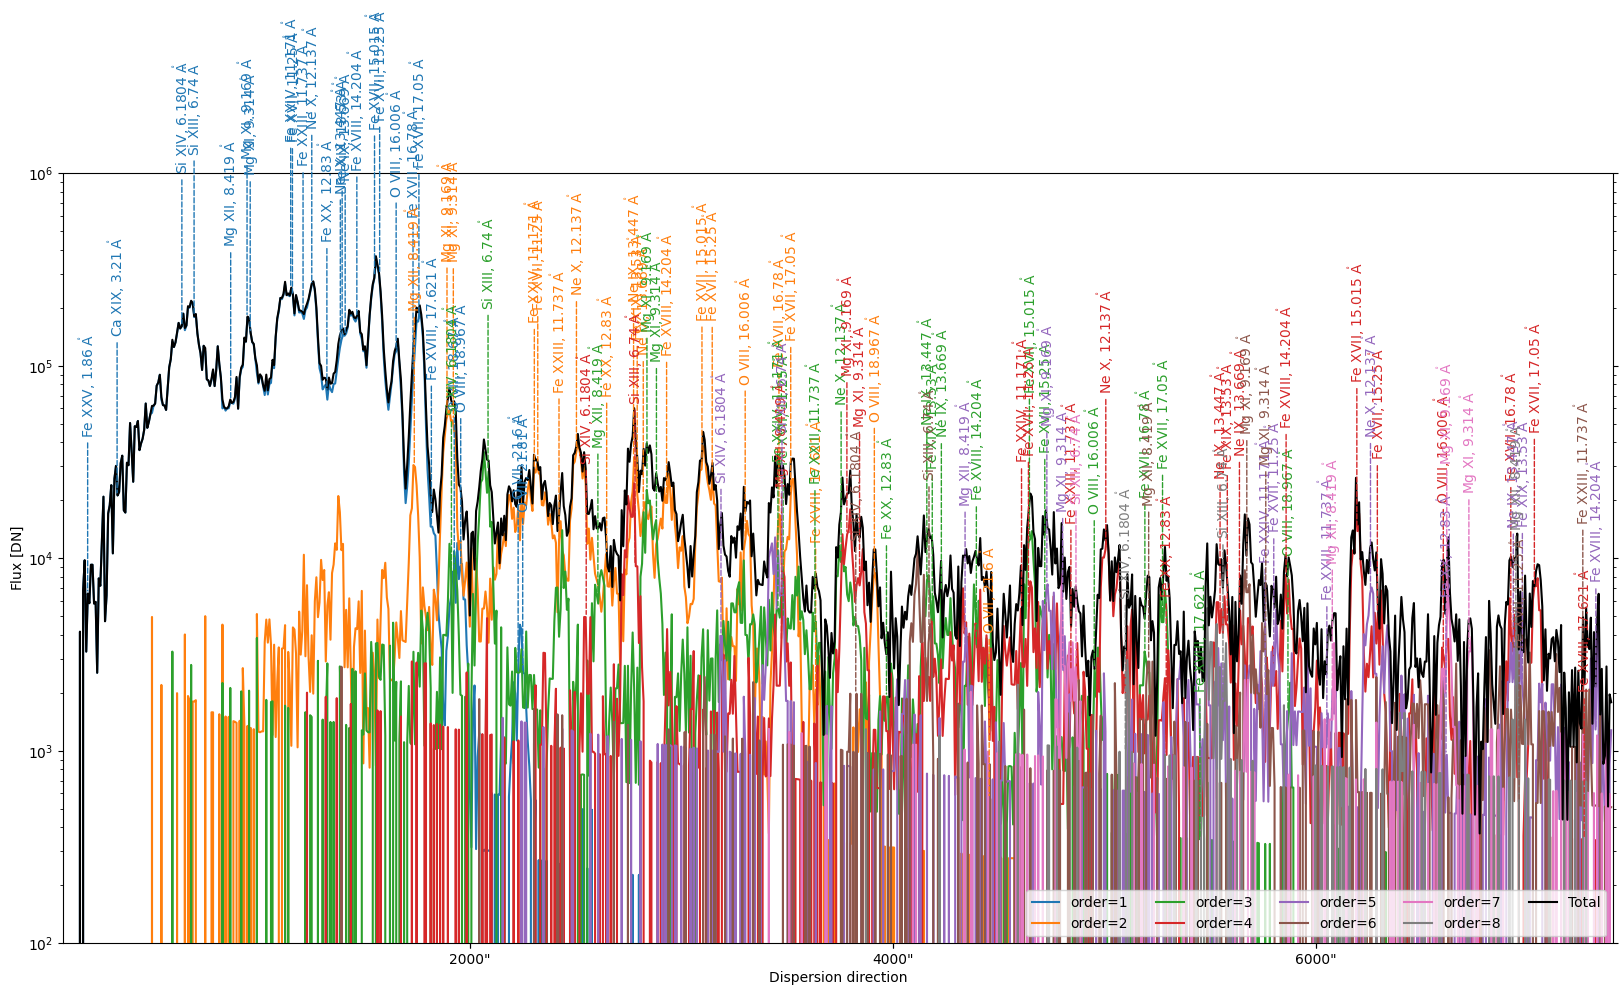

In [24]:
filenames = sorted((results_root / f'caspi_spectra_m1_be_thin' / 'detector_images').glob('spectrogram_slot*.fits'),
                   key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
components_overlap = []
for filename in filenames:
    order = int(filename.name.split('.')[0].split('_')[-1])
    if order > 0 and order <9:
        overlap_component = read_overlappogram(filename)
        components_overlap.append(overlap_component[:,:500,:].rebin((1,500,1),operation=np.sum))
full_overlap = read_overlappogram(results_root / f'caspi_spectra_m1_be_thin' / 'detector_images' / 'all_components.fits')
full_overlap = full_overlap[:,:500,:].rebin((1,500,1),operation=np.sum)
plot_labeled_spectrum(components_overlap,
                      full_overlap,
                      line_list,
                      SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(overlap_component.wcs)),
                      threshold=0.1,
                      labels=[f'order={i}' for i in range(1,len(components_overlap)+1)],
                      x_lim=(1010,2000),
                      y_lim=(1e2,1e6))

/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide


(<Figure size 2000x1000 with 1 Axes>,
 <WCSAxes: ylabel='Flux [$\\mathrm{ph}$]'>)

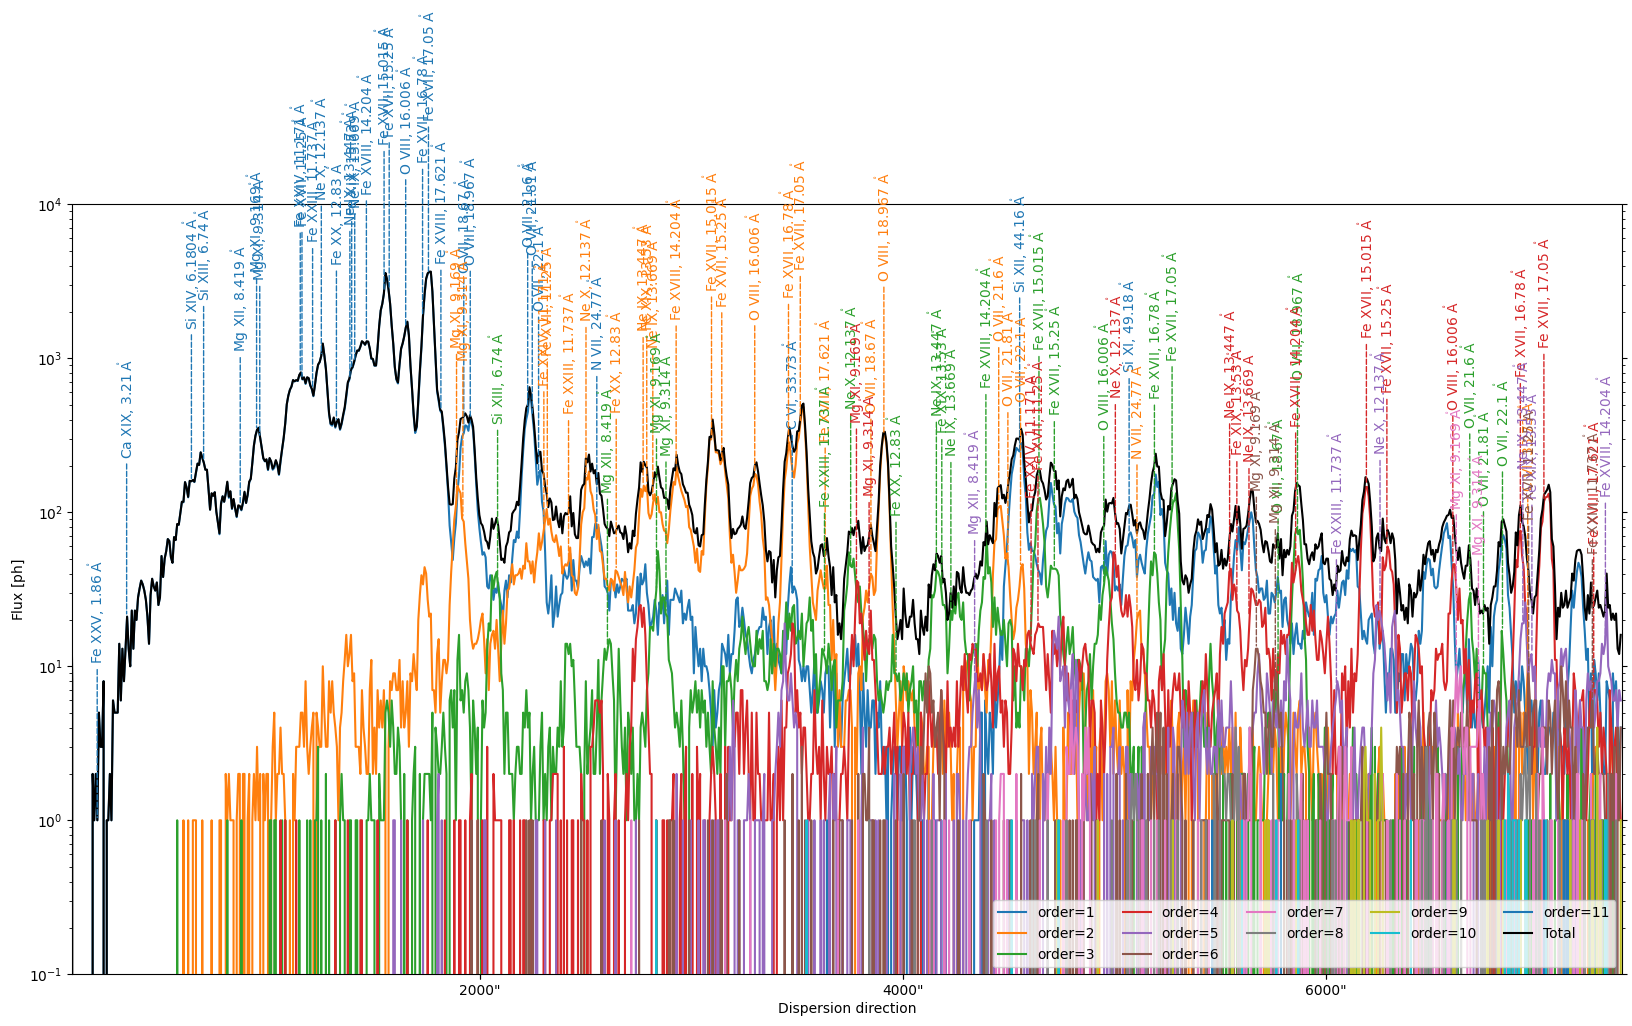

In [6]:
filenames = sorted((results_root / f'm1_photon_1min' / 'detector_images').glob('spectrogram_slot*.fits'),
                   key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
components_overlap = []
for filename in filenames:
    order = int(filename.name.split('.')[0].split('_')[-1])
    if order > 0: #and order <9:
        overlap_component = read_overlappogram(filename)
        components_overlap.append(overlap_component[:,:500,:].rebin((1,500,1),operation=np.sum))
full_overlap = read_overlappogram(results_root / f'm1_photon_1min' / 'detector_images' / 'all_components.fits')
full_overlap = full_overlap[:,:500,:].rebin((1,500,1),operation=np.sum)
plot_labeled_spectrum(components_overlap,
                      full_overlap,
                      line_list,
                      SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(overlap_component.wcs)),
                      threshold=0.1,
                      labels=[f'order={i}' for i in range(1,len(components_overlap)+1)],
                      x_lim=(1010,2000),
                      y_lim=(0.1,1e4))

/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide


(<Figure size 2000x1000 with 1 Axes>,
 <WCSAxes: ylabel='Flux [$\\mathrm{ph}$]'>)

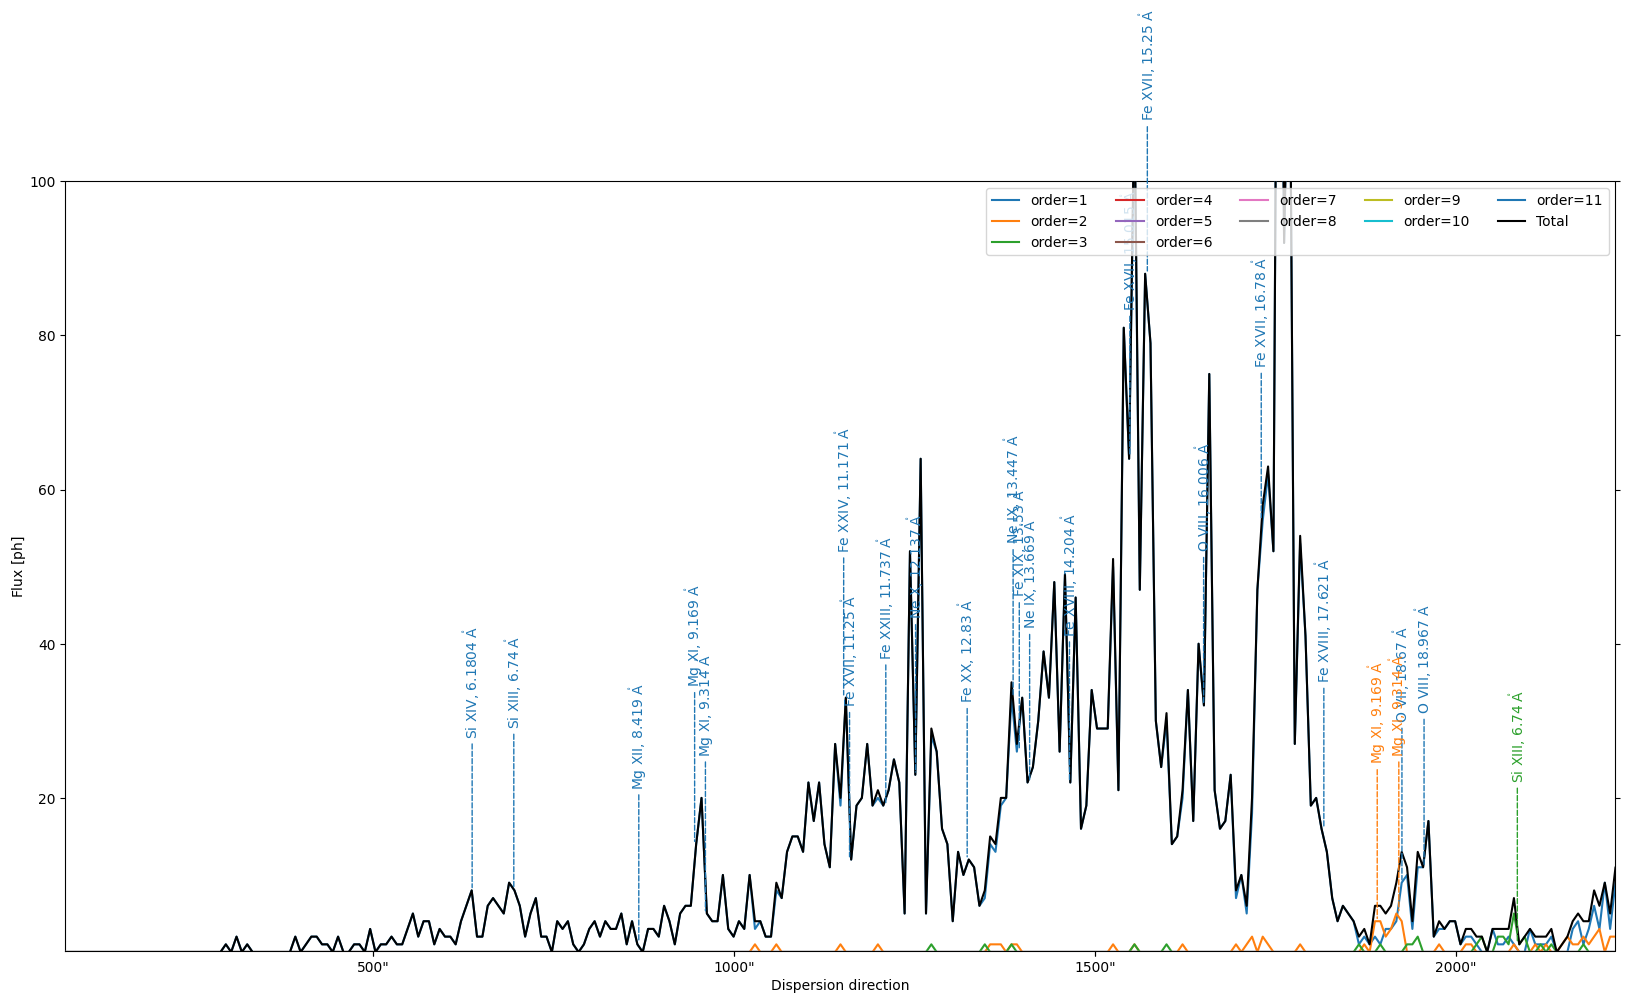

In [15]:
filenames = sorted((results_root / f'm1_photon_1min' / 'detector_images').glob('spectrogram_slot*.fits'),
                   key=lambda x: int(x.name.split('.')[0].split('_')[-1]))
components_overlap = []
for filename in filenames:
    order = int(filename.name.split('.')[0].split('_')[-1])
    if order > 0: #and order <9:
        overlap_component = read_overlappogram(filename)
        components_overlap.append(overlap_component[:,275:276,:])#.rebin((1,500,1),operation=np.sum))
full_overlap = read_overlappogram(results_root / f'm1_photon_1min' / 'detector_images' / 'all_components.fits')
full_overlap = full_overlap[:,275:276,:]#.rebin((1,500,1),operation=np.sum)
plot_labeled_spectrum(components_overlap,
                      full_overlap,
                      line_list,
                      SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(overlap_component.wcs)),
                      threshold=0.1,
                      labels=[f'order={i}' for i in range(1,len(components_overlap)+1)],
                      x_lim=(1010,1300),
                      y_lim=(0.1,1e2),
                      log_y=False,
)